<a href="https://colab.research.google.com/github/veryHapppy/study_ai/blob/main/deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 개념

In [ ]:
'''
MLP (multi-layer Perceptron)
수치 데이터들을 연결하며 학습
입력층 : 피처들이 들어오는 곳
은닉층 : 정보에 가중치 곱하고 더하고 패턴 추출하는 곳
출력층 : 최종 정답 출력
모든 데이터를 수치적 곡선 관계로 이해 -> 스케일링이 필수

활성화 함수 : 출력을 결정하는 함수 (시그모이드, ReLU, tanh 등)

퍼셉트론 : 딥러닝의 최소 단위 (뉴런의 동작 윈리를 수학적으로 만든 알고리즘)
y = w * x + b

손실함수 : loss를 측정하는 함수 (이진 분류에서는 BCELoss)

역전파 : 출력층에서 발생한 loss를 거슬러가며 가중치를 조절

옵티마이저 : 가중치를 얼마나, 어떤 방향으로 바꿀지 결정하는 최적화 알고리즘 (Adam)


'''

'\nMLP (multi-layer Perceptron)\n수치 데이터들을 연결하며 학습\n입력층 : 피처들이 들어오는 곳\n은닉층 : 정보에 가중치 곱하고 더하고 패턴 추출하는 곳\n출력층 : 최종 정답 출력\n모든 데이터를 수치적 곡선 관계로 이해 -> 스케일링이 필수\n\n활성화 함수 : 출력을 결정하는 함수 (시그모이드, ReLU, tanh 등)\n\n퍼셉트론 : 딥러닝의 최소 단위 (뉴런의 동작 윈리를 수학적으로 만든 알고리즘)\ny = w * x + b\n\n손실함수 : loss를 측정하는 함수 (이진 분류에서는 BCELoss)\n\n역전파 : 출력층에서 발생한 loss를 거슬러가며 가중치를 조절\n\n옵티마이저 : 가중치를 얼마나, 어떤 방향으로 바꿀지 결정하는 최적화 알고리즘 (Adam)\n\n\n'

# import

In [ ]:
!pip install optuna
!pip install plotly
!pip install konlpy
!pip install transformers datasets accelerate
!pip install evaluate
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import optuna
import optuna.visualization as vis
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import itertools
from sklearn.metrics import confusion_matrix
from konlpy.tag import Okt
import urllib.request
import pickle
from collections import Counter
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.model_selection import train_test_split
import evaluate
from transformers import pipeline

from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.7 MB/s eta 0:00:00
Mounted at /content/drive


# MLP

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 2. 데이터셋 로드
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader: 데이터를 64개씩 쪼개서 모델에게 전달합니다.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 3. 모델 설계 (다층 퍼셉트론, MLP)
class MNIST_MLP(nn.Module):
    def __init__(self):
        super(MNIST_MLP, self).__init__()
        # MNIST 이미지는 28x28 = 784개의 픽셀입니다.
        self.fc1 = nn.Linear(784, 128) # 입력층 -> 은닉층 1
        self.fc2 = nn.Linear(128, 64)  # 은닉층 1 -> 은닉층 2
        self.fc3 = nn.Linear(64, 10)   # 은닉층 2 -> 출력층 (0~9까지 10개 분류)
        self.relu = nn.ReLU()          # 활성화 함수

    def forward(self, x):
        # x의 형태: (배치사이즈, 1, 28, 28) -> (배치사이즈, 784)로 평탄화합니다.
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x) # 마지막은 CrossEntropyLoss에서 Softmax를 처리하므로 여기선 생략합니다.
        return x # CrossEntropyLoss가 아닌 경우 : torch.softmax(x, dim=1)

model = MNIST_MLP()

# 4. 손실 함수와 옵티마이저
criterion = nn.CrossEntropyLoss() # 다중 분류용 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.001) # 똑똑한 운전수

# 5. 학습 루프 (간략 버전)
for epoch in range(5): # 5번 반복 학습
    for images, labels in train_loader:
        # 순전파
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 역전파 및 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/5], Loss: {loss.item():.4f}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 476kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.68MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.0MB/s]


Epoch [1/5], Loss: 0.1290
Epoch [2/5], Loss: 0.1077
Epoch [3/5], Loss: 0.2374
Epoch [4/5], Loss: 0.0107
Epoch [5/5], Loss: 0.0117


In [ ]:
# 1. 모델을 평가 모드로 전환 (Dropout이나 Batch Normalization 등이 있으면 평가용으로 동작함)
model.eval()

correct = 0
total = 0

# 2. 기울기 계산 비활성화 (메모리 절약 및 속도 향상)
with torch.no_grad():
    for images, labels in test_loader:
        # 이미지를 한 줄로 펴서 모델에 입력
        outputs = model(images)

        # outputs에는 10개 숫자에 대한 점수(Logits)가 들어있음
        # 그 중 가장 점수가 높은 인덱스가 모델의 예측값
        _, predicted = torch.max(outputs.data, 1)

        # 전체 개수와 맞힌 개수를 카운트
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'10,000장 테스트 이미지에 대한 모델의 정확도: {100 * correct / total:.2f}%')

10,000장 테스트 이미지에 대한 모델의 정확도: 96.72%


# 데이터 증강

In [ ]:
# 데이터 증강 : 한정된 데이터를 인위적으로 변화시킴, 학습데이터를 늘림
transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(p=0.5), # 50% 확률로 좌우 반전
    transforms.RandomRotation(degrees=15),  # 15도 내외로 무작위 회전
    transforms.ColorJitter(brightness=0.2), # 밝기 조절
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# CNN

In [ ]:
# MLP는 이미지를 1차원으로 변환
# CNN(합성곱 신경망)은 2차원을 그대로 사용하여 특징을 찾음
# 필터 : 이미지를 돌아다니며 특징을 찾음 -> 해당 필터의 가중치를 학습
# 필터의 개수 = 특징의 개수
# 스트라이드 : 필터가 한번에 이동하는 칸 수
# 패딩 : 가장자리에 0을 채워 넣음
# 풀링 : 특징 중에서 가장 강한 특징만 남기고 나머지는 버려서 데이터 크기를 줄임 (Max Pooling)

# dropout : 무작위로 뉴런의 일부를 꺼버림
# 배치 정규화 : layer를 지날 때마다 데이터를 정규화 시킴 (학습속도 빨라짐, ReLU의 단점 커)

In [ ]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        # 첫 번째 특징 추출 층: 1채널(흑백) 입력 -> 16개 필터 사용 (3x3 크기)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        # 두 번째 특징 추출 층: 16개 채널 입력 -> 32개 필터 사용
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # 이미지 크기를 절반으로 줄이는 풀링 층
        self.pool = nn.MaxPool2d(2, 2)

        # 마지막 분류 층 (Fully Connected)
        # 28x28 이미지가 풀링을 2번 거치면 7x7 크기가 됩니다. (28->14->7)
        # 최종 채널 수(32) * 7 * 7 = 1568
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10) # 0~9까지 10개 분류

    def forward(self, x):
        # Conv -> ReLU -> Pool
        x = self.pool(F.relu(self.conv1(x))) # (batch, 16, 14, 14)
        x = self.pool(F.relu(self.conv2(x))) # (batch, 32, 7, 7)

        # 한 줄로 펴기 (Flatten)
        x = x.view(-1, 32 * 7 * 7)

        # 분류기 통과
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"현재 사용 중인 장치: {device}")
model = MNIST_CNN().to(device)

# 3. 손실 함수와 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



현재 사용 중인 장치: cuda


In [ ]:


# 손실과 정확도를 기록하기 위한 리스트
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(5):
    # --- [Train Phase] ---
    model.train() # 학습 모드
    train_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # --- [Validation Phase] ---
    model.eval() # 평가 모드 (중요!)
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad(): # 기울기 계산 끔 (메모리 절약)
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 정확도 계산
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 에폭별 결과 출력
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    accuracy = 100 * correct / total

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(accuracy)

    print(f'Epoch [{epoch+1}/5] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {accuracy:.2f}%')

Epoch [1/5] | Train Loss: 0.1811 | Val Loss: 0.0679 | Val Acc: 97.91%
Epoch [2/5] | Train Loss: 0.0519 | Val Loss: 0.0472 | Val Acc: 98.49%
Epoch [3/5] | Train Loss: 0.0385 | Val Loss: 0.0403 | Val Acc: 98.61%
Epoch [4/5] | Train Loss: 0.0289 | Val Loss: 0.0323 | Val Acc: 98.97%
Epoch [5/5] | Train Loss: 0.0231 | Val Loss: 0.0357 | Val Acc: 98.76%


In [ ]:
class AdvancedCNN(nn.Module):
    def __init__(self):
        super(AdvancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) # 배치 정규화 추가

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)

        # 드롭아웃 추가 (파라미터 수가 급격히 증가하기 때문에 과적합이 일어날 수 있음)
        self.dropout = nn.Dropout(0.25)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Conv -> BN -> ReLU -> Pool 순서
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        x = x.view(-1, 64 * 7 * 7)

        x = F.relu(self.fc1(x))
        x = self.dropout(x) # 학습 중에만 뉴런을 끕니다
        x = self.fc2(x)
        return x

# 2D CNN optuna

In [ ]:
class MNIST_CNN(nn.Module):
    def __init__(self, conv1_filters, conv2_filters, dropout_p):
        super(MNIST_CNN, self).__init__()
        # 첫 번째 Conv: 1채널 -> 설정된 필터 수
        self.conv1 = nn.Conv2d(1, conv1_filters, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(conv1_filters)
        # 두 번째 Conv: 첫 번째 필터 수 -> 두 번째 필터 수
        self.conv2 = nn.Conv2d(conv1_filters, conv2_filters, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(conv2_filters)

        self.pool = nn.MaxPool2d(2, 2)

        # MaxPool을 두 번 거치면 28x28 이미지는 7x7이 됩니다. (28 -> 14 -> 7)
        # 따라서 Linear 층의 입력은 (마지막 필터 수 * 7 * 7)입니다.
        self.fc1 = nn.Linear(conv2_filters * 7 * 7, 128)
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x)))) # 14x14
        x = self.pool(torch.relu(self.bn2(self.conv2(x)))) # 7x7
        x = x.view(x.size(0), -1) # 펴주기
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# 1. 학습용 (증강 포함)
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=10), # MNIST는 10도 정도가 적당합니다.
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 2. 테스트/검증용 (증강 제외 - 깨끗한 원본)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 데이터셋 적용
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

def train_and_eval(model, train_loader, test_loader, optimizer, criterion):
    # 3 에폭 정도만 학습해서 성능을 확인 (시간 절약)
    for epoch in range(2):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # 최종 검증 단계
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

def objective_step1(trial):
    # 1. 학습 환경 변수만 제안받음
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    # 데이터 로더 설정
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=2, pin_memory=True)

    # 모델은 기본 구조로 고정
    model = MNIST_CNN(
        conv1_filters=16,
        conv2_filters=32,
        dropout_p=0.5
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # 학습 (1~2 에폭만 짧게 수행)
    acc = train_and_eval(model, train_loader, test_loader, optimizer, criterion)
    return acc

# 1단계 실행
study1 = optuna.create_study(direction="maximize")
study1.optimize(objective_step1, n_trials=25) # 시도횟수

best_lr = study1.best_params['lr']
best_batch_size = study1.best_params['batch_size']
best_weight_decay = study1.best_params['weight_decay']
print(f"1단계 완료, 최적의 lr: {best_lr}, batch_size: {best_batch_size}, weight_decay: {best_weight_decay}")

[I 2025-12-22 18:03:14,766] A new study created in memory with name: no-name-aefc9336-1a33-4d0b-9275-d78bde1754d3
[I 2025-12-22 18:03:52,439] Trial 0 finished with value: 98.69 and parameters: {'lr': 0.0004717255319975357, 'batch_size': 64, 'weight_decay': 1.379821093741735e-06}. Best is trial 0 with value: 98.69.
[I 2025-12-22 18:04:23,611] Trial 1 finished with value: 98.51 and parameters: {'lr': 0.0009879710394372293, 'batch_size': 256, 'weight_decay': 1.117676274627095e-05}. Best is trial 0 with value: 98.69.
[I 2025-12-22 18:04:56,572] Trial 2 finished with value: 98.47 and parameters: {'lr': 0.0007011454883971085, 'batch_size': 256, 'weight_decay': 7.718545880305483e-05}. Best is trial 0 with value: 98.69.
[I 2025-12-22 18:05:30,828] Trial 3 finished with value: 96.94 and parameters: {'lr': 8.356739915386612e-05, 'batch_size': 128, 'weight_decay': 0.000517619007591407}. Best is trial 0 with value: 98.69.
[I 2025-12-22 18:06:08,548] Trial 4 finished with value: 98.55 and parameter

1단계 완료, 최적의 lr: 0.0018299971263402272, batch_size: 64, weight_decay: 3.2539857315122865e-06


In [ ]:
def objective_step2(trial):
    # 1단계에서 찾은 최적값 고정
    lr = best_lr
    batch_size = best_batch_size
    weight_decay = best_weight_decay
    # 🔍 필터 수(채널 수) 탐색 공간 설정
    # 16부터 128까지 16 단위로 탐색
    n_filters_conv1 = trial.suggest_int("n_filters_conv1", 16, 64, step=16)
    n_filters_conv2 = trial.suggest_int("n_filters_conv2", 32, 128, step=16)
    dropout_p = trial.suggest_float("dropout_p", 0.2, 0.5)

    # 데이터 로더
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=2, pin_memory=True)

    # 모델 생성 (필터 수를 인자로 전달)
    model = MNIST_CNN(
        conv1_filters=n_filters_conv1,
        conv2_filters=n_filters_conv2,
        dropout_p=dropout_p
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=best_weight_decay)
    criterion = nn.CrossEntropyLoss()

    # 학습 및 성적 측정
    acc = train_and_eval(model, train_loader, test_loader, optimizer, criterion)
    return acc

# 2단계 실행
study2 = optuna.create_study(direction="maximize")
study2.optimize(objective_step2, n_trials=15)

print(f"2단계 완료, 최적의 구조: {study2.best_params}")

[I 2025-12-22 18:17:46,897] A new study created in memory with name: no-name-7ed87766-0318-462f-b736-339b946b5862
[I 2025-12-22 18:18:25,380] Trial 0 finished with value: 98.83 and parameters: {'n_filters_conv1': 48, 'n_filters_conv2': 64, 'dropout_p': 0.3014964868445164}. Best is trial 0 with value: 98.83.
[I 2025-12-22 18:19:03,940] Trial 1 finished with value: 98.9 and parameters: {'n_filters_conv1': 48, 'n_filters_conv2': 112, 'dropout_p': 0.23038127356969923}. Best is trial 1 with value: 98.9.
[I 2025-12-22 18:19:46,330] Trial 2 finished with value: 98.56 and parameters: {'n_filters_conv1': 16, 'n_filters_conv2': 112, 'dropout_p': 0.3232763045153463}. Best is trial 1 with value: 98.9.
[I 2025-12-22 18:20:23,628] Trial 3 finished with value: 98.8 and parameters: {'n_filters_conv1': 32, 'n_filters_conv2': 64, 'dropout_p': 0.32317981706205406}. Best is trial 1 with value: 98.9.
[I 2025-12-22 18:21:01,476] Trial 4 finished with value: 98.63 and parameters: {'n_filters_conv1': 64, 'n_f

2단계 완료, 최적의 구조: {'n_filters_conv1': 64, 'n_filters_conv2': 96, 'dropout_p': 0.21735982521211675}


In [ ]:
best_params = study2.best_params

# 2. 그 레시피대로 '진짜 최종 모델'을 생성합니다.
final_model = MNIST_CNN(
    conv1_filters=best_params['n_filters_conv1'],
    conv2_filters=best_params['n_filters_conv2'],
    dropout_p=best_params['dropout_p']
).to(device)

train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
optimizer = optim.Adam(final_model.parameters(), lr=best_lr, weight_decay=best_weight_decay)
criterion = nn.CrossEntropyLoss()

print(f"최종 모델 구성 완료")

history = {'train_loss': [], 'val_acc': []}

epochs = 20
for epoch in range(epochs):
    final_model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = final_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # 에폭마다 검증 (테스트셋 활용)
    final_model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = final_model(images)
            _, pred = torch.max(outputs, 1)
            correct += (pred == labels).sum().item()

    acc = 100 * correct / len(test_dataset)
    avg_loss = total_loss / len(train_loader)

    history['train_loss'].append(avg_loss)
    history['val_acc'].append(acc)

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}, Acc: {acc:.2f}%")

print("최종 모델 학습 완료")

최종 모델 구성 완료
Epoch [1/20] - Loss: 0.2234, Acc: 98.42%
Epoch [2/20] - Loss: 0.0965, Acc: 99.09%
Epoch [3/20] - Loss: 0.0749, Acc: 98.81%
Epoch [4/20] - Loss: 0.0631, Acc: 99.23%
Epoch [5/20] - Loss: 0.0561, Acc: 99.11%
Epoch [6/20] - Loss: 0.0477, Acc: 99.17%
Epoch [7/20] - Loss: 0.0461, Acc: 99.27%
Epoch [8/20] - Loss: 0.0427, Acc: 99.40%
Epoch [9/20] - Loss: 0.0376, Acc: 99.25%
Epoch [10/20] - Loss: 0.0349, Acc: 99.34%
Epoch [11/20] - Loss: 0.0340, Acc: 99.36%
Epoch [12/20] - Loss: 0.0309, Acc: 99.23%
Epoch [13/20] - Loss: 0.0288, Acc: 99.32%
Epoch [14/20] - Loss: 0.0264, Acc: 99.37%
Epoch [15/20] - Loss: 0.0272, Acc: 99.39%
Epoch [16/20] - Loss: 0.0243, Acc: 99.35%
Epoch [17/20] - Loss: 0.0249, Acc: 99.38%
Epoch [18/20] - Loss: 0.0232, Acc: 99.41%
Epoch [19/20] - Loss: 0.0226, Acc: 99.33%
Epoch [20/20] - Loss: 0.0216, Acc: 99.31%
최종 모델 학습 완료


In [ ]:
#테스트

def predict_my_number(image_path, model):
    # 1. 이미지 불러오기 및 전처리
    img = Image.open(image_path).convert('L') # 흑백 변환
    img = img.resize((28, 28)) # 28x28 크기 조절

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    img_tensor = transform(img).unsqueeze(0).to(device) # 배치 차원 추가

    # 만약 배경이 흰색이고 글자가 검은색이라면 반전시켜야 할 수도 있습니다.
    img_tensor = 1.0 - img_tensor

    # 2. 예측
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)
        prob = torch.nn.functional.softmax(output, dim=1) # 확률값 확인

    print(f"모델의 예측: {predicted.item()}")
    print(f"확률: {prob[0][predicted.item()]*100:.2f}%")

    plt.imshow(img, cmap='gray')
    plt.show()

# predict_my_number('본인의_파일_경로.png', final_model)

# 2D CNN (color) optuna

In [ ]:
class ColorCNN(nn.Module):
    def __init__(self, conv1_filters, conv2_filters, conv3_filters, dropout_p):
        super(ColorCNN, self).__init__()
        # 입력 채널 3으로 변경
        self.conv1 = nn.Conv2d(3, conv1_filters, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(conv1_filters)

        self.conv2 = nn.Conv2d(conv1_filters, conv2_filters, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(conv2_filters)

        self.conv3 = nn.Conv2d(conv2_filters, conv3_filters, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(conv3_filters)

        self.pool = nn.MaxPool2d(2, 2)

        # CIFAR-10은 보통 32x32 크기이므로, 풀링 2번 거치면 8x8이 됩니다.
        # (32 -> 16 -> 8)
        self.fc1 = nn.Linear(conv3_filters * 4 * 4, 256) # 입력 크기 주의!
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# 1. 학습용 (증강 포함)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # 컬러 이미지에선 필수!
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# 2. 테스트/검증용 (증강 제외 - 깨끗한 원본)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# 데이터셋 적용
train_color_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_color_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

test_loader = DataLoader(test_color_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

def train_and_eval(model, train_loader, test_loader, optimizer, criterion):
    # 3 에폭 정도만 학습해서 성능을 확인 (시간 절약)
    for epoch in range(2):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # 최종 검증 단계
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

def objective_step1(trial):
    # 1. 학습 환경 변수만 제안받음
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    # 데이터 로더 설정
    train_loader = DataLoader(train_color_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=2, pin_memory=True)

    # 모델은 기본 구조로 고정
    model = ColorCNN(
        conv1_filters=32,
        conv2_filters=64,
        conv3_filters=128,
        dropout_p=0.5
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # 학습 (1~2 에폭만 짧게 수행)
    acc = train_and_eval(model, train_loader, test_loader, optimizer, criterion)
    return acc

# 1단계 실행
study1 = optuna.create_study(direction="maximize")
study1.optimize(objective_step1, n_trials=25) # 시도횟수

best_lr = study1.best_params['lr']
best_batch_size = study1.best_params['batch_size']
best_weight_decay = study1.best_params['weight_decay']
print(f"1단계 완료, 최적의 lr: {best_lr}, batch_size: {best_batch_size}, weight_decay: {best_weight_decay}")

[I 2025-12-22 18:49:50,616] A new study created in memory with name: no-name-440edb59-393e-48c6-b435-5afaae8b5a3f
[I 2025-12-22 18:50:34,794] Trial 0 finished with value: 68.3 and parameters: {'lr': 0.0002905100874449443, 'batch_size': 64, 'weight_decay': 2.7552200731310065e-06}. Best is trial 0 with value: 68.3.
[I 2025-12-22 18:51:13,500] Trial 1 finished with value: 60.31 and parameters: {'lr': 0.0026624712826349437, 'batch_size': 128, 'weight_decay': 4.936275479640616e-05}. Best is trial 0 with value: 68.3.
[I 2025-12-22 18:51:56,474] Trial 2 finished with value: 56.81 and parameters: {'lr': 4.0858314257833495e-05, 'batch_size': 64, 'weight_decay': 1.9270951879388252e-05}. Best is trial 0 with value: 68.3.
[I 2025-12-22 18:52:39,418] Trial 3 finished with value: 68.38 and parameters: {'lr': 0.00034745650882137203, 'batch_size': 64, 'weight_decay': 0.00018661050874938293}. Best is trial 3 with value: 68.38.
[I 2025-12-22 18:53:16,076] Trial 4 finished with value: 56.01 and parameter

1단계 완료, 최적의 lr: 0.0005425560313900526, batch_size: 64, weight_decay: 3.109803735238418e-06


In [ ]:
def objective_step2(trial):
    # 1단계에서 찾은 최적값 고정
    lr = best_lr
    batch_size = best_batch_size
    weight_decay = best_weight_decay
    # 🔍 필터 수(채널 수) 탐색 공간 설정
    # 16부터 128까지 16 단위로 탐색
    n_filters_conv1 = trial.suggest_int("n_filters_conv1", 32, 64, step=16)
    n_filters_conv2 = trial.suggest_int("n_filters_conv2", 64, 128, step=16)
    n_filters_conv3 = trial.suggest_int("n_filters_conv3", 128, 256, step=16)
    dropout_p = trial.suggest_float("dropout_p", 0.2, 0.5)

    # 데이터 로더
    train_loader = DataLoader(train_color_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=2, pin_memory=True)

    # 모델 생성 (필터 수를 인자로 전달)
    model = ColorCNN(
        conv1_filters=n_filters_conv1,
        conv2_filters=n_filters_conv2,
        conv3_filters=n_filters_conv3,
        dropout_p=dropout_p
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=best_weight_decay)
    criterion = nn.CrossEntropyLoss()

    # 학습 및 성적 측정
    acc = train_and_eval(model, train_loader, test_loader, optimizer, criterion)
    return acc

# 2단계 실행
study2 = optuna.create_study(direction="maximize")
study2.optimize(objective_step2, n_trials=15)

print(f"2단계 완료, 최적의 구조: {study2.best_params}")

[I 2025-12-22 19:09:03,702] A new study created in memory with name: no-name-257f4b70-5e57-47c9-a82d-1946f4a3635d
[I 2025-12-22 19:09:46,301] Trial 0 finished with value: 69.77 and parameters: {'n_filters_conv1': 32, 'n_filters_conv2': 128, 'n_filters_conv3': 240, 'dropout_p': 0.40979013111761575}. Best is trial 0 with value: 69.77.
[I 2025-12-22 19:10:27,616] Trial 1 finished with value: 68.24 and parameters: {'n_filters_conv1': 32, 'n_filters_conv2': 80, 'n_filters_conv3': 192, 'dropout_p': 0.2632328614844624}. Best is trial 0 with value: 69.77.
[I 2025-12-22 19:11:08,418] Trial 2 finished with value: 70.87 and parameters: {'n_filters_conv1': 32, 'n_filters_conv2': 80, 'n_filters_conv3': 128, 'dropout_p': 0.2874252515022173}. Best is trial 2 with value: 70.87.
[I 2025-12-22 19:11:49,938] Trial 3 finished with value: 69.71 and parameters: {'n_filters_conv1': 32, 'n_filters_conv2': 112, 'n_filters_conv3': 192, 'dropout_p': 0.42725678169771975}. Best is trial 2 with value: 70.87.
[I 202

2단계 완료, 최적의 구조: {'n_filters_conv1': 64, 'n_filters_conv2': 80, 'n_filters_conv3': 128, 'dropout_p': 0.2631557253979908}


In [ ]:
best_params = study2.best_params

# 2. 그 레시피대로 '진짜 최종 모델'을 생성합니다.
final_model = ColorCNN(
    conv1_filters=best_params['n_filters_conv1'],
    conv2_filters=best_params['n_filters_conv2'],
    conv3_filters=best_params['n_filters_conv3'],
    dropout_p=best_params['dropout_p']
).to(device)

train_loader = DataLoader(train_color_dataset, batch_size=best_batch_size, shuffle=True)
optimizer = optim.Adam(final_model.parameters(), lr=best_lr, weight_decay=best_weight_decay)
criterion = nn.CrossEntropyLoss()

print(f"최종 모델 구성 완료")

history = {'train_loss': [], 'val_acc': []}

epochs = 30
for epoch in range(epochs):
    final_model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = final_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # 에폭마다 검증 (테스트셋 활용)
    final_model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = final_model(images)
            _, pred = torch.max(outputs, 1)
            correct += (pred == labels).sum().item()

    acc = 100 * correct / len(test_color_dataset)
    avg_loss = total_loss / len(train_loader)

    history['train_loss'].append(avg_loss)
    history['val_acc'].append(acc)

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}, Acc: {acc:.2f}%")

print("최종 모델 학습 완료")

최종 모델 구성 완료
Epoch [1/30] - Loss: 1.2988, Acc: 64.80%
Epoch [2/30] - Loss: 0.9623, Acc: 71.60%
Epoch [3/30] - Loss: 0.8505, Acc: 72.22%
Epoch [4/30] - Loss: 0.7778, Acc: 75.95%
Epoch [5/30] - Loss: 0.7278, Acc: 75.02%
Epoch [6/30] - Loss: 0.6872, Acc: 76.86%
Epoch [7/30] - Loss: 0.6506, Acc: 78.66%
Epoch [8/30] - Loss: 0.6220, Acc: 79.75%
Epoch [9/30] - Loss: 0.5996, Acc: 78.85%
Epoch [10/30] - Loss: 0.5749, Acc: 79.72%
Epoch [11/30] - Loss: 0.5556, Acc: 79.70%
Epoch [12/30] - Loss: 0.5348, Acc: 80.15%
Epoch [13/30] - Loss: 0.5197, Acc: 81.13%
Epoch [14/30] - Loss: 0.4998, Acc: 81.37%
Epoch [15/30] - Loss: 0.4861, Acc: 81.55%
Epoch [16/30] - Loss: 0.4753, Acc: 81.77%
Epoch [17/30] - Loss: 0.4615, Acc: 82.47%
Epoch [18/30] - Loss: 0.4462, Acc: 82.63%
Epoch [19/30] - Loss: 0.4366, Acc: 82.82%
Epoch [20/30] - Loss: 0.4202, Acc: 82.93%
Epoch [21/30] - Loss: 0.4079, Acc: 83.14%
Epoch [22/30] - Loss: 0.4091, Acc: 83.15%
Epoch [23/30] - Loss: 0.3947, Acc: 82.95%
Epoch [24/30] - Loss: 0.3835, A

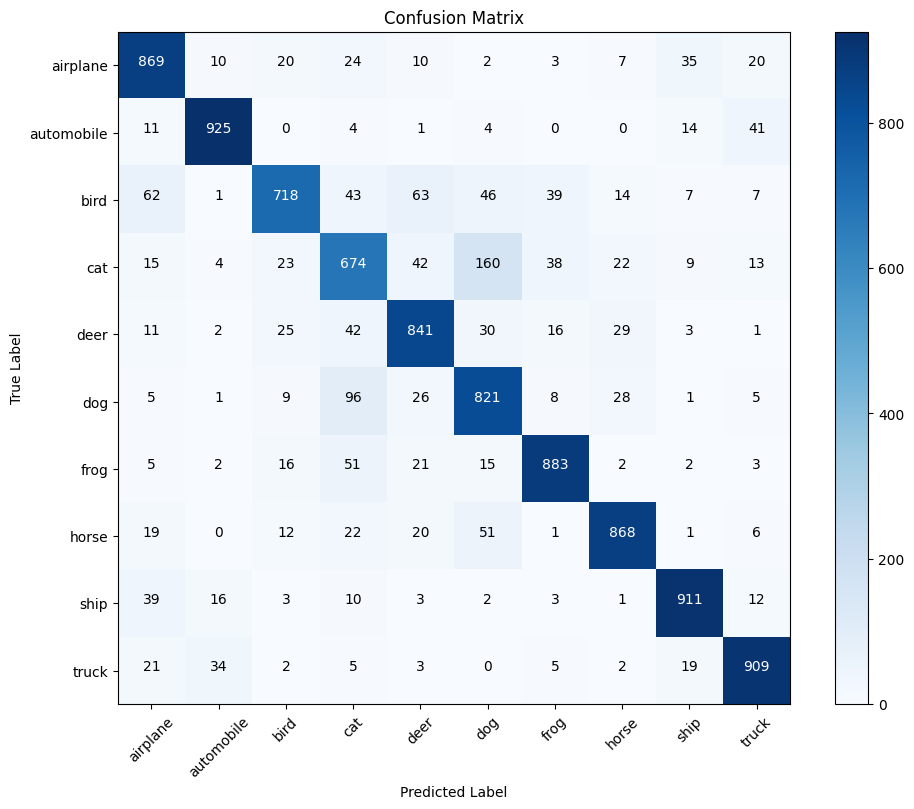

In [ ]:
def plot_confusion_matrix(model, test_loader, classes):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # 수치 표시
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(final_model, test_loader, classes)

# 심화 CNN

ResNet
VGGNet
EfficientNet

# 자연어 처리

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
train_data = pd.read_table('ratings_train.txt')

print(f"전체 리뷰 개수: {len(train_data)}")

train_data = train_data.drop_duplicates(subset=['document'])
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)

train_data['document'] = train_data['document'].replace('', np.nan)
train_data = train_data.dropna(how='any')

print(f"정제 후 리뷰 개수: {len(train_data)}")

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
new_words = ['영화', '제', '보는', '나', '내', '거', '에서'] # 내 데이터에만 유독 많은 단어
stopwords.extend(new_words)

okt = Okt()
X_train = []

for sentence in train_data['document']:
    # 토큰화 + 어간 추출(Stemming)
    temp_X = okt.morphs(sentence, stem=True)
    # 불용어 제거
    temp_X = [word for word in temp_X if not word in stopwords]
    X_train.append(temp_X)

print(X_train[0])

전체 리뷰 개수: 150000
정제 후 리뷰 개수: 145791
['아', '더빙', '진짜', '짜증나다', '목소리']


In [ ]:
with open('ratings_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)

print("토큰화 완료 데이터 저장")

토큰화 완료 데이터 저장


In [ ]:
with open('ratings_train.pkl', 'rb') as f:
    X_train = pickle.load(f)

print(f"데이터 로드")

In [ ]:
# 리뷰 전체의 단어 사전
all_words = np.hstack(X_train)
word_counts = Counter(all_words) # {'재밌다': 12345, '최악': 876, '감독': 542}

threshold = 3
#빈도 수 낮은 단어 버리기
vocab = [word for word, count in word_counts.items() if count >= threshold] # ['재밌다', '최악', '감독']
#딕셔너리 (단어 : 인덱스) 인덱스 매기기
word_to_index = {word: i+2 for i, word in enumerate(vocab)} # [(0, '재밌다'), (1, '최악'), (2, '감독')]
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

def encode_text(token_list):
    return [word_to_index.get(word, 1) for word in token_list]

X_train_encoded = [encode_text(sentence) for sentence in X_train]

In [ ]:
# 패딩 구현
def pad_sequences(sentences, max_len):
    # 리뷰개수 X 최대 길이
    features = np.zeros((len(sentences), max_len), dtype=int)
    for i, sms in enumerate(sentences):
        if len(sms) != 0:
            # 문장이 max_len보다 길면 자르고, 짧으면 앞에 0(Padding)이 유지됨
            features[i, -len(sms):] = np.array(sms)[:max_len]
    return features

max_len = 30 # 리뷰의 적당한 길이
X_train_padded = pad_sequences(X_train_encoded, max_len)

print(f"패딩 완료된 첫 번째 리뷰: \n{X_train_padded[0]}")

패딩 완료된 첫 번째 리뷰: 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 3 4 5 6]


In [ ]:
# 데이터 셋으로 변환
y_train = torch.LongTensor(train_data['label'].values)
X_train_tensor = torch.LongTensor(X_train_padded)

# + LSTM

In [ ]:
# Dataset과 DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        # 1. 임베딩 층: 숫자를 의미 있는 벡터로 변환
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # 2. LSTM 층: 문장의 맥락을 파악
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # 3. 전결합 층: 최종 긍정(1)/부정(0) 판단
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        # LSTM의 출력 중 마지막 시점의 결과만 사용합니다.
        _, (hidden, _) = self.lstm(embedded)
        return self.fc(hidden[-1])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"현재 사용 중인 장치: {device}")

vocab_size = len(word_to_index)

# 1. 하이퍼파라미터 설정
embedding_dim = 100  # 단어를 표현할 벡터의 차원
hidden_dim = 128     # LSTM의 메모리 크기
output_dim = 2       # 0(부정) 또는 1(긍정)
learning_rate = 0.001
epochs = 5

# 2. 모델, 손실함수, 최적화 도구 선언
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss() # 분류 문제이므로 교차 엔트로피 사용
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam 최적화

# 3. 학습 루프 시작
model.train()
for epoch in range(epochs):
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # 가중치 초기화
        optimizer.zero_grad()

        # 순전파 (Forward)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 역전파 (Backward) 및 가중치 업데이트
        loss.backward()
        optimizer.step()

        # 통계 계산
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f'Epoch [{epoch+1}/{epochs}] - Loss: {total_loss/len(train_loader):.4f}, Acc: {acc:.2f}%')

현재 사용 중인 장치: cuda
Epoch [1/5] - Loss: 0.4225, Acc: 80.08%
Epoch [2/5] - Loss: 0.3213, Acc: 86.03%
Epoch [3/5] - Loss: 0.2688, Acc: 88.69%
Epoch [4/5] - Loss: 0.2176, Acc: 91.17%
Epoch [5/5] - Loss: 0.1648, Acc: 93.59%


In [ ]:
# 실전
def predict_sentiment(model, word_to_index, sentence):
    model.eval()
    # 1. 전처리: 한글만 남기기
    import re
    sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', sentence)

    # 2. 토큰화 및 불용어 제거 (아까 사용한 okt와 stopwords 활용)
    tokens = okt.morphs(sentence, stem=True)
    tokens = [word for word in tokens if word not in stopwords]

    # 3. 정수 인코딩 및 패딩
    encoded = [word_to_index.get(word, 1) for word in tokens] # 사전에 없으면 <UNK>(1)
    padded = pad_sequences([encoded], max_len=30) # 위에서 정의한 pad_sequences 함수 사용

    # 4. 모델 예측
    inputs = torch.LongTensor(padded).to(device)
    with torch.no_grad():
        outputs = model(inputs)
        # 확률로 변환 (Softmax)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        score = probs[0][1].item() # 긍정일 확률

    if score > 0.5:
        print(f"[{sentence}] -> 긍정 리뷰입니다. (확률: {score*100:.2f}%)")
    else:
        print(f"[{sentence}] -> 부정 리뷰입니다. (확률: {(1-score)*100:.2f}%)")

# 테스트 예시
predict_sentiment(model, word_to_index, "와 이 영화 진짜 소름 돋을 정도로 재밌네요!")
predict_sentiment(model, word_to_index, "시간 아까워요. 보지 마세요.")

[와 이 영화 진짜 소름 돋을 정도로 재밌네요] -> 긍정 리뷰입니다. (확률: 99.64%)
[시간 아까워요 보지 마세요] -> 부정 리뷰입니다. (확률: 99.98%)


# BERT

In [ ]:
# 한국어 전문 BERT 모델 (Beomi의 KcBERT)
# 전처리
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

# 2. 로드 (불필요한 결측치 제거까지 포함하는 게 좋습니다)
train_df = pd.read_table('ratings_train.txt').dropna()
test_df = pd.read_table('ratings_test.txt').dropna()

train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)

# 샘플링해서 조금만 사용
#train_df = train_df.sample(n=10000, random_state=42)
#val_df = val_df.sample(n=2000, random_state=42)
#test_df = test_df.sample(n=2000, random_state=42)

#모델 다른거로 변경 가능
model_name = "beomi/kcbert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 3. 데이터 전처리 함수 정의
def tokenize_function(examples):
    # max_length는 GPU 메모리에 맞춰 조절 (보통 64, 128 사용)
    return tokenizer(examples["document"], padding="max_length", truncation=True, max_length=64)

# 4. HuggingFace Dataset으로 변환
train_dataset = Dataset.from_pandas(train_df).map(tokenize_function, batched=True)
val_dataset = Dataset.from_pandas(val_df).map(tokenize_function, batched=True)
test_dataset = Dataset.from_pandas(test_df).map(tokenize_function, batched=True)

# 5. BERT 전용 형식으로 정리 (필요없는 컬럼 삭제 및 이름 변경)
train_dataset = train_dataset.remove_columns(['document'])
train_dataset = train_dataset.rename_column("label", "labels")
val_dataset = val_dataset.remove_columns(['document'])
val_dataset = val_dataset.rename_column("label", "labels")
test_dataset = test_dataset.remove_columns(['document'])
test_dataset = test_dataset.rename_column("label", "labels")

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# 2. 학습 설정 (에폭, 배치 크기 등)
training_args = TrainingArguments(
    output_dir='./results',          # 결과 저장 경로

    num_train_epochs=3,              # 에폭 수 (보통 2~5)
    learning_rate=2e-5,              # 2e-5(0.00002) ~ 5e-5(0.00005)
    per_device_train_batch_size=16,  # 배치 크기 (메모리 부족 시 8로 줄임)
    per_device_eval_batch_size=16,

    warmup_steps=500,                # 학습 초기 안정화를 위한 단계 (데이터가 수만개 : 1000 이상)
    weight_decay=0.01,               # 과적합 방지
    logging_dir='./logs',            # 로그 저장 경로
    eval_strategy="epoch",           # 에폭마다 성능 검증
    save_strategy="epoch",           # 에폭마다 모델 저장
    load_best_model_at_end=True      # 가장 좋은 모델을 마지막에 로드
)

# 3. 학습 시작! (이게 바로 Fine-tuning입니다)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.456800,0.368258
2,0.307800,0.369148
3,0.189700,0.578895


TrainOutput(global_step=1875, training_loss=0.27505279337565103, metrics={'train_runtime': 420.7721, 'train_samples_per_second': 71.298, 'train_steps_per_second': 4.456, 'total_flos': 986666457600000.0, 'train_loss': 0.27505279337565103, 'epoch': 3.0})

In [ ]:
# 테스트
metric = evaluate.load("accuracy")

# 2. 정확도 계산 함수 정의
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # metric.compute를 사용하여 정확도 계산
    return metric.compute(predictions=predictions, references=labels)

# 3. Trainer에 함수 주입 및 평가
trainer.compute_metrics = compute_metrics
final_results = trainer.evaluate(eval_dataset=test_dataset)

print(final_results)

# 실제 문장 테스트
# 학습된 모델과 토크나이저를 감성 분석 파이프라인으로 연결
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=0)

# 테스트해볼 문장들
sentences = [
    "영화 진짜 개꿀잼 ㅋㅋㅋ 꼭 보세요",
    "내 시간 돌려줘... 진짜 노잼임",
    "처음엔 좀 지루했는데 끝으로 갈수록 소름 돋네요"
]

results = classifier(sentences)

for i, res in enumerate(results):
    if res['label'] == 'LABEL_1' :
      label = "긍정"
    else :
      label = "부정"
    print(f"리뷰: {sentences[i]} => 결과: {label} (신뢰도: {res['score']:.2f})")

Device set to use cuda:0


{'eval_loss': 0.36825796961784363, 'eval_accuracy': 0.8305, 'eval_runtime': 7.7166, 'eval_samples_per_second': 259.181, 'eval_steps_per_second': 16.199, 'epoch': 3.0}
리뷰: 영화 진짜 개꿀잼 ㅋㅋㅋ 꼭 보세요 => 결과: 긍정 (신뢰도: 0.97)
리뷰: 내 시간 돌려줘... 진짜 노잼임 => 결과: 부정 (신뢰도: 0.82)
리뷰: 처음엔 좀 지루했는데 끝으로 갈수록 소름 돋네요 => 결과: 긍정 (신뢰도: 0.81)


# BERT + optuna


In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

# 2. 로드 (불필요한 결측치 제거까지 포함하는 게 좋습니다)
train_df = pd.read_table('ratings_train.txt').dropna()
test_df = pd.read_table('ratings_test.txt').dropna()

# 파라미터 찾기용 데이터
train_sample = train_df.sample(n=20000, random_state=42)
test_sample = test_df.sample(n=5000, random_state=42)

#모델 다른거로 변경 가능
model_name = "beomi/kcbert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 3. 데이터 전처리 함수 정의
def tokenize_function(examples):
    # max_length는 GPU 메모리에 맞춰 조절 (보통 64, 128 사용)
    return tokenizer(examples["document"], padding="max_length", truncation=True, max_length=64)

train_optuna = Dataset.from_pandas(train_sample).map(tokenize_function, batched=True)
test_optuna = Dataset.from_pandas(test_sample).map(tokenize_function, batched=True)

train_dataset = Dataset.from_pandas(train_df).map(tokenize_function, batched=True)
test_dataset = Dataset.from_pandas(test_df).map(tokenize_function, batched=True)

columns_to_remove = ['document', 'id'] if 'id' in train_df.columns else ['document']

# Optuna용 데이터 정리
train_optuna = train_optuna.remove_columns(columns_to_remove)
train_optuna = train_optuna.rename_column("label", "labels")
test_optuna = test_optuna.remove_columns(columns_to_remove)
test_optuna = test_optuna.rename_column("label", "labels")

# 전체 데이터 정리 (최종 학습용)
train_dataset = train_dataset.remove_columns(columns_to_remove)
train_dataset = train_dataset.rename_column("label", "labels")
test_dataset = test_dataset.remove_columns(columns_to_remove)
test_dataset = test_dataset.rename_column("label", "labels")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/149995 [00:00<?, ? examples/s]

Map:   0%|          | 0/49997 [00:00<?, ? examples/s]

In [ ]:
metric = evaluate.load("accuracy")

training_args = TrainingArguments(
    output_dir='./results',          # 결과 저장 경로

    #num_train_epochs=3,              # 에폭 수 (보통 2~5)
    #learning_rate=2e-5,              # 2e-5(0.00002) ~ 5e-5(0.00005)
    #per_device_train_batch_size=16,  # 배치 크기 (메모리 부족 시 8로 줄임)
    per_device_eval_batch_size=16,

    warmup_steps=500,                # 학습 초기 안정화를 위한 단계 (데이터가 수만개 : 1000 이상)
    #warmup_ratio=0.1 # 이거 사용하기도 함
    weight_decay=0.01,               # 과적합 방지
    logging_dir='./logs',            # 로그 저장 경로
    eval_strategy="epoch",           # 에폭마다 성능 검증
    save_strategy="epoch",           # 에폭마다 모델 저장
    load_best_model_at_end=True      # 가장 좋은 모델을 마지막에 로드
)

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2) # 마지막 선택지 개수

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # metric.compute를 사용하여 정확도 계산
    return metric.compute(predictions=predictions, references=labels)

# 2. Trainer 재정의 (기존 설정 활용)
trainer = Trainer(
    model_init=model_init,             # model 대신 model_init 사용
    args=training_args,                # 아까 만든 training_args 그대로 사용
    train_dataset=train_optuna,
    eval_dataset=test_optuna,
    compute_metrics=compute_metrics    # 아까 만든 정확도 계산 함수
)

# 3. 하이퍼파라미터 탐색 범위 정의 함수
def my_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 3),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 32]),
    }

# 4. 탐색 시작!
best_run = trainer.hyperparameter_search(
    direction="maximize",      # 정확도를 최대화하라
    backend="optuna",          # Optuna 엔진 사용
    hp_space=my_hp_space,      # 범위 지정
    n_trials=5                 # 5번 시도 (BERT는 무거우니 적게 시작하세요)
)

print("최고의 파라미터:", best_run.hyperparameters)

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-12-25 03:29:12,156] A new study created in memory with name: no-name-42622df0-6c33-42ab-a155-8e418daad7d7
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss,Accuracy
1,0.434000,0.325663,0.867600
2,0.266400,0.328788,0.877800
3,0.172500,0.414357,0.877800


[I 2025-12-25 03:40:45,685] Trial 0 finished with value: 0.8778 and parameters: {'learning_rate': 2.1918047120420798e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 0.8778.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁██
eval/loss,▁▁█
eval/runtime,▁▃█
eval/samples_per_second,█▆▁
eval/steps_per_second,█▆▁
train/epoch,▁▂▄▅▆██
train/global_step,▁▂▄▅▆██
train/grad_norm,█▅▁
train/learning_rate,█▅▁
train/loss,█▄▁
eval/accuracy,0.8778


Epoch,Training Loss,Validation Loss,Accuracy
1,0.423100,0.329877,0.860600
2,0.262900,0.341639,0.874000
3,0.162100,0.471407,0.877400


[I 2025-12-25 03:52:02,827] Trial 1 finished with value: 0.8774 and parameters: {'learning_rate': 3.760845023141325e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 0.8778.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▇█
eval/loss,▁▂█
eval/runtime,▄▁█
eval/samples_per_second,▅█▁
eval/steps_per_second,▅█▁
train/epoch,▁▂▄▅▆██
train/global_step,▁▂▄▅▆██
train/grad_norm,█▃▁
train/learning_rate,█▅▁
train/loss,█▄▁
eval/accuracy,0.8774


Epoch,Training Loss,Validation Loss,Accuracy
1,0.442200,0.326579,0.866000
2,0.271300,0.329817,0.871800
3,0.185200,0.393190,0.874600


[I 2025-12-25 04:03:28,397] Trial 2 finished with value: 0.8746 and parameters: {'learning_rate': 1.759046444008971e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 0.8778.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆█
eval/loss,▁▁█
eval/runtime,█▁▁
eval/samples_per_second,▁██
eval/steps_per_second,▁██
train/epoch,▁▂▄▅▆██
train/global_step,▁▂▄▅▆██
train/grad_norm,█▄▁
train/learning_rate,█▅▁
train/loss,█▃▁
eval/accuracy,0.8746


Epoch,Training Loss,Validation Loss,Accuracy
1,0.429000,0.324075,0.868000
2,0.264100,0.334725,0.878200
3,0.165900,0.445611,0.878600


[I 2025-12-25 04:14:51,854] Trial 3 finished with value: 0.8786 and parameters: {'learning_rate': 2.6624020628991406e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 32}. Best is trial 3 with value: 0.8786.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁██
eval/loss,▁▂█
eval/runtime,█▆▁
eval/samples_per_second,▁▃█
eval/steps_per_second,▁▃█
train/epoch,▁▂▄▅▆██
train/global_step,▁▂▄▅▆██
train/grad_norm,█▆▁
train/learning_rate,█▅▁
train/loss,█▄▁
eval/accuracy,0.8786


Epoch,Training Loss,Validation Loss,Accuracy
1,0.438600,0.324643,0.865000
2,0.268200,0.325034,0.875400
3,0.177600,0.401386,0.878000


[I 2025-12-25 04:27:12,881] Trial 4 finished with value: 0.878 and parameters: {'learning_rate': 1.899869699787572e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 32}. Best is trial 3 with value: 0.8786.


최고의 파라미터: {'learning_rate': 2.6624020628991406e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 32}


In [ ]:
final_training_args = TrainingArguments(
    output_dir='./final_results',
    num_train_epochs=best_run.hyperparameters['num_train_epochs'],
    learning_rate=best_run.hyperparameters['learning_rate'],
    per_device_train_batch_size=best_run.hyperparameters['per_device_train_batch_size'],
    per_device_eval_batch_size=best_run.hyperparameters['per_device_train_batch_size'], # 동일하게 설정
    warmup_steps=500,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",            # 에폭마다 저장 시도는 하되
    save_total_limit=1,               # 👈 딱 1개만 남기고 나머지는 지워라!
    load_best_model_at_end=True,      # 👈 가장 점수 좋은 놈을 마지막에 불러와라
    metric_for_best_model="accuracy"
)

# 3. 최종 학습용 Trainer 생성
final_trainer = Trainer(
    model=AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2),
    args=final_training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# 4. 진짜 마지막 학습!
final_trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.267300,0.248296,0.896974
2,0.174800,0.275533,0.902634
3,0.099600,0.354692,0.903534


TrainOutput(global_step=14064, training_loss=0.19551183257900406, metrics={'train_runtime': 5000.6698, 'train_samples_per_second': 89.985, 'train_steps_per_second': 2.812, 'total_flos': 1.47995035307712e+16, 'train_loss': 0.19551183257900406, 'epoch': 3.0})

In [ ]:
final_score = final_trainer.evaluate()
print(f"최종 정확도: {final_score['eval_accuracy']:.4f}")

# 모델 저장
final_trainer.save_model("./my_best_bert_model")
tokenizer.save_pretrained("./my_best_bert_model")

save_path = "/content/drive/MyDrive/Colab Notebooks/models/review_bert"

# 모델과 토크나이저 저장
final_trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

print(f"모델이 구글 드라이브의 {save_path}에 저장되었습니다!")

최종 정확도: 0.9035
모델이 구글 드라이브의 /content/drive/MyDrive/Colab Notebooks/pth에 저장되었습니다!


In [ ]:

save_path = "/content/drive/MyDrive/Colab Notebooks/models/review_bert"

# 모델 로드
#device = torch.device("cpu")
model = AutoModelForSequenceClassification.from_pretrained(save_path)
tokenizer = AutoTokenizer.from_pretrained(save_path)

# 테스트
text = "별로임"
inputs = tokenizer(text, return_tensors="pt")
with torch.no_grad(): # 추론 시에는 메모리 절약을 위해 필수!
    outputs = model(**inputs)
logits = outputs.logits
prediction = torch.argmax(logits, dim=-1) # 가장 큰 값의 인덱스(0 또는 1) 추출

if prediction == 1:
    print("긍정입니다!")
else:
    print("부정입니다!")

부정입니다!


# 모델 저장 / 불러오기

In [ ]:
# 가중치만 저장하므로 모델 구조(클래스 코드)도 저장해야함

# 저장
torch.save(final_model.state_dict(), 'cifar10_cnn_model.pth')
print("모델 가중치 저장 완료")

# 불러오기
new_model = MNIST_CNN().to(device)

new_model.load_state_dict(torch.load('mnist_cnn.pth'))

# 3. 평가 모드로 전환 (반드시 필요!)
new_model.eval()
print("모델 가중치 불러오기 완료")

모델 가중치 저장 완료


In [ ]:
# 모델과 토크나이저 저장
model.save_pretrained("./my_bert_model")
tokenizer.save_pretrained("./my_bert_model")


# 불러오기
model_path = "./my_bert_model"

# 1. 저장된 모델과 토크나이저 불러오기
loaded_model = AutoModelForSequenceClassification.from_pretrained(model_path)
loaded_tokenizer = AutoTokenizer.from_pretrained(model_path)

# 2. 실전 테스트를 위한 파이프라인 만들기
# (device=0은 GPU 사용, CPU만 있다면 생략하거나 -1로 설정)
classifier = pipeline("sentiment-analysis", model=loaded_model, tokenizer=loaded_tokenizer, device=0)

# 시각화

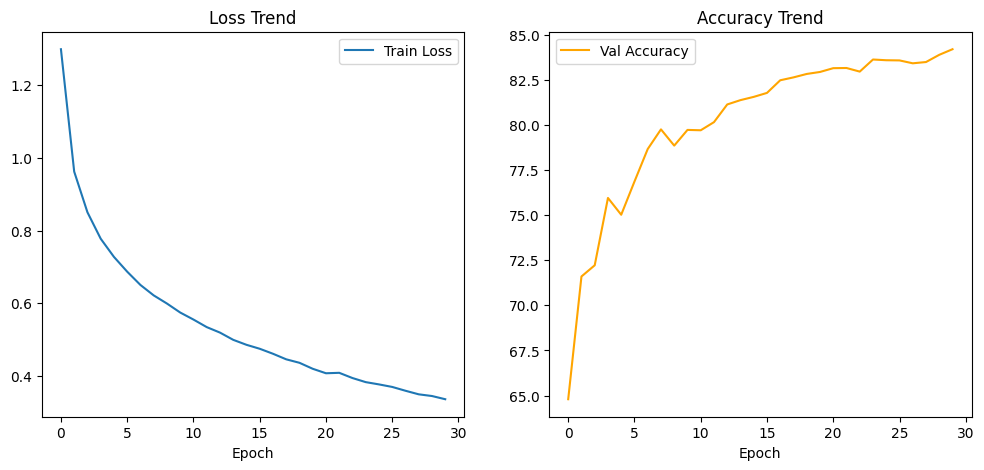

In [ ]:
# 1. 어떤 파라미터가 가장 중요했나?
vis.plot_param_importances(study2)

# 2. 최적화 과정 그래프 (정확도가 어떻게 상승했나)
vis.plot_optimization_history(study2)


plt.figure(figsize=(12, 5))
# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.title('Loss Trend')
plt.xlabel('Epoch')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history['val_acc'], label='Val Accuracy', color='orange')
plt.title('Accuracy Trend')
plt.xlabel('Epoch')
plt.legend()

plt.show()

# 수학

In [ ]:
# 데이터의 평균, 표준편차 구하기

def get_mean_std(dataset):
    # 데이터를 한 배치씩 꺼내오기 위한 로더 (셔플 필요 없음)
    loader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=2)

    mean = 0.
    std = 0.
    total_images = 0

    for images, _ in loader:
        # images: [batch_size, 3, height, width]
        batch_size = images.size(0)

        # 1. 픽셀들을 채널별로 펼치기: [batch_size, 3, H*W]
        images = images.view(batch_size, images.size(1), -1)

        # 2. 채널별 평균 계산 (dim=2에 대해 평균)
        mean += images.mean(2).sum(0)

        # 3. 채널별 표준편차 계산
        std += images.std(2).sum(0)

        total_images += batch_size

    # 4. 전체 이미지 수로 나누기
    mean /= total_images
    std /= total_images

    return mean, std

# 사용 예시 (Normalize가 적용되지 않은 ToTensor만 있는 데이터셋 필요)
print(get_mean_std(train_dataset))